## Data

- https://www.governing.com/gov-data/safety-justice/law-enforcement-police-department-employee-totals-for-cities.html
- https://www.census.gov/data/tables/time-series/demo/popest/2010s-total-cities-and-towns.html#ds
- https://simplemaps.com/data/us-cities
- https://killedbypolice.net/
- https://docs.google.com/spreadsheets/d/1dKmaV_JiWcG8XBoRgP8b4e9Eopkpgt7FL7nyspvzAsE/edit#gid=0
- https://mappingpoliceviolence.org/aboutthedata
- https://www.taxpolicycenter.org/statistics/state-and-local-general-expenditures-capita
- https://public.opendatasoft.com/explore/dataset/us-cities-demographics/table/?dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6InVzLWNpdGllcy1kZW1vZ3JhcGhpY3MiLCJvcHRpb25zIjp7fX0sImNoYXJ0cyI6W3siYWxpZ25Nb250aCI6dHJ1ZSwidHlwZSI6ImNvbHVtbiIsImZ1bmMiOiJBVkciLCJ5QXhpcyI6Im1lZGlhbl9hZ2UiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiIjRkY1MTVBIn1dLCJ4QXhpcyI6ImNpdHkiLCJtYXhwb2ludHMiOjUwLCJzb3J0IjoiIn1dLCJ0aW1lc2NhbGUiOiIiLCJkaXNwbGF5TGVnZW5kIjp0cnVlLCJhbGlnbk1vbnRoIjp0cnVlfQ%3D%3D

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [214]:
data_cov = "28122020"
# clean fatal encounters from missing values
pop = pd.read_csv('data/raw/uscities.csv') #, encoding = "ISO-8859-1"
us_pop = pd.read_csv('data/raw/POPTOTUSA647NWDB.csv')
pop_race = pd.read_csv('data/raw/us-cities-demographics.csv', sep=";")
state_abr = pd.read_csv('data/raw/abbr-name-list.csv')
police_officers = pd.read_csv('data/raw/police_officers.csv')
votes = pd.read_csv('data/raw/countypres_2000-2016.csv')
spending = pd.read_csv('data/raw/results.csv', skiprows=[0,1])
df = pd.read_csv(f"data/raw/fatal_encounters_{data_cov}.csv")
# get counties centroids
counties = gpd.read_file("data/raw/counties/tl_2017_us_county.shp")
df.shape

(29360, 28)

In [215]:
df = df.dropna(subset=['Longitude', 'Latitude'])
df.shape

(29359, 28)

In [14]:
df.to_csv(f'data/processed/fatal_encounters_cl_{data_cov}.csv')

In [209]:
# counties['NAME'] = counties['name']

In [163]:
# counties['centroid'] = counties['geometry'].centroid

In [61]:
# aggregated since 2000
df['death_count'] = 1 
# df = df[["Subject's name", "Subject's age", "Subject's race", "Subject's gender", 
#          "Date of injury resulting in death (month/day/year)", 
#          "Location of death (county)", "Latitude", "Longitude",
#          "Date (Year)", "death_count"]]
df[["Latitude", "Longitude","death_count"]] = df[["Latitude", "Longitude","death_count"]].apply(pd.to_numeric)



df = df.groupby("Location of death (county)").agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()
df.columns = ["county", "Latitude", "Longitude","death_count"]

df = df.dropna(subset=['Longitude', 'Latitude'])

df.to_csv("data/countiesDeaths.csv")

In [77]:
# by month/year
df['death_count'] = 1 
# df = df[["Subject's name", "Subject's age", "Subject's race", "Subject's gender", 
#          "Date of injury resulting in death (month/day/year)", 
#          "Location of death (county)", "Latitude", "Longitude",
#          "Date (Year)", "death_count"]]

df['month'] = df['Date of injury resulting in death (month/day/year)'].str[:2]

df['month_year'] = df['month'].astype('str') + "/" + df['Date (Year)'].astype('str')

df[["Latitude", "Longitude","death_count"]] = df[["Latitude", "Longitude","death_count"]].apply(pd.to_numeric)



df = df.groupby(["Location of death (county)", "month_year"]).agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()
df.columns = ["county", "date", "Latitude", "Longitude","death_count"]

df = df.dropna(subset=['Longitude', 'Latitude'])

df.to_csv("data/citiesYearDeaths.csv")

### Clean data for Bubble Map

In [38]:
# by year
df['Latitude'] = df['Latitude'].str.strip(", ")
df['Date (Year)'] = pd.to_datetime(df['Date of injury resulting in death (month/day/year)']).dt.year
df = df[df['Date (Year)']<=2020]
df['death_count'] = 1 
# df = df[["Subject's name", "Subject's age", "Subject's race", "Subject's gender", 
#          "Date of injury resulting in death (month/day/year)", 
#          "Location of death (county)", "Latitude", "Longitude",
#          "Date (Year)", "death_count"]]

df[["Latitude", "Longitude","death_count"]] = df[["Latitude", "Longitude","death_count"]].apply(pd.to_numeric)



df = df.groupby(["Location of death (city)", "Date (Year)"]).agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()
df.columns = ["county", "date", "Latitude", "Longitude","death_count"]

In [7]:
# add population for that city


In [39]:
df = df.dropna(subset=['Longitude', 'Latitude'])

df.to_csv(f"data/citiesYearDeaths_{data_cov}.csv")

### Clean data for Cartogram

In [45]:
df['0'] = 1 
df['1'] = 1 
# df = df[["Subject's name", "Subject's age", "Subject's race", "Subject's gender", 
#          "Date of injury resulting in death (month/day/year)", 
#          "Location of death (county)", "Latitude", "Longitude",
#          "Date (Year)", "death_count"]]

# df[["Latitude", "Longitude","death_count"]] = df[["Latitude", "Longitude","death_count"]].apply(pd.to_numeric)



df_tot = df.groupby(["State"]).sum()
df_tot = df_tot[["0", "1"]]

In [46]:
df_tot.to_dict("index")

{'AK': {'0': 121, '1': 121},
 'AL': {'0': 647, '1': 647},
 'AR': {'0': 364, '1': 364},
 'AZ': {'0': 856, '1': 856},
 'CA': {'0': 4688, '1': 4688},
 'CO': {'0': 639, '1': 639},
 'CT': {'0': 137, '1': 137},
 'DC': {'0': 83, '1': 83},
 'DE': {'0': 60, '1': 60},
 'FL': {'0': 1782, '1': 1782},
 'GA': {'0': 1109, '1': 1109},
 'HI': {'0': 107, '1': 107},
 'IA': {'0': 271, '1': 271},
 'ID': {'0': 143, '1': 143},
 'IL': {'0': 1070, '1': 1070},
 'IN': {'0': 557, '1': 557},
 'KS': {'0': 401, '1': 401},
 'KY': {'0': 398, '1': 398},
 'LA': {'0': 617, '1': 617},
 'MA': {'0': 195, '1': 195},
 'MD': {'0': 521, '1': 521},
 'ME': {'0': 99, '1': 99},
 'MI': {'0': 857, '1': 857},
 'MN': {'0': 332, '1': 332},
 'MO': {'0': 894, '1': 894},
 'MS': {'0': 416, '1': 416},
 'MT': {'0': 103, '1': 103},
 'NC': {'0': 620, '1': 620},
 'ND': {'0': 38, '1': 38},
 'NE': {'0': 198, '1': 198},
 'NH': {'0': 56, '1': 56},
 'NJ': {'0': 520, '1': 520},
 'NM': {'0': 404, '1': 404},
 'NV': {'0': 391, '1': 391},
 'NY': {'0': 667

In [171]:
df_tot.to_csv(f"data/processed/StateDeaths_{data_cov}.csv")

In [61]:
df_tot.columns = ['total_deaths', 'total']

In [62]:
state_spend = pd.read_csv("data/raw/spending_state.csv")

In [71]:
state_pop = pd.read_html("https://worldpopulationreview.com/states")[0]

In [72]:
state_pop = pd.merge(state_pop[['State', '2020 Pop.']], state_abr, right_on="name", left_on="State").drop(["name", "State"], axis=1).rename(columns={"abbreviation": "state"})

In [63]:
state_spend['Policing Per Capita Spend'] = pd.to_numeric(state_spend['Policing Per Capita Spend'].str.strip("$"))
state_spend['Policing % of Total Spend'] = pd.to_numeric(state_spend['Policing % of Total Spend'].str.strip("%"))/100
state_spend['Policing Expenditures ($ Millions)'] = pd.to_numeric(state_spend['Policing Expenditures ($ Millions)'].str.strip("$").str.replace(',', ''))
state_spend = pd.merge(state_abr, state_spend, left_on="name", right_on="State").drop(["name", "State", "Rank", "Score"], axis=1).rename(columns={"abbreviation": "state"})
spend_deaths = pd.merge(df_tot.reset_index(), state_spend, left_on="State", right_on="state")
spend_deaths = pd.merge(spend_deaths, state_pop, on="state")

In [76]:
spend_deaths['deaths_capita'] = spend_deaths['total_deaths']/spend_deaths['2020 Pop.']

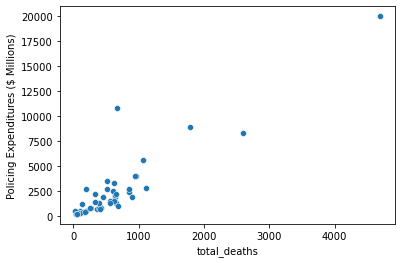

In [65]:
import seaborn as sns
sns.scatterplot(data=spend_deaths, x="total_deaths", y="Policing Expenditures ($ Millions)")

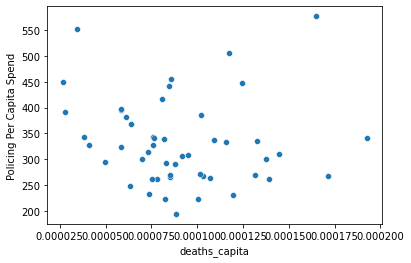

In [77]:
import seaborn as sns
sns.scatterplot(data=spend_deaths, x="deaths_capita", y="Policing Per Capita Spend")

In [82]:
# https://www.americashealthrankings.org/explore/annual/measure/Crime/state/ALL
crime = pd.read_csv("data/raw/2020-Annual.csv") 

In [84]:
crime = pd.merge(state_abr, crime[crime['Measure Name'] == 'Violent Crime'][['State Name', 'Value']], 
                 left_on="name", right_on='State Name').drop(["name", "State Name"], axis=1).rename(columns={"abbreviation": "state", "Value":"crime_hthou"})

In [93]:
spend_deaths_crime = pd.merge(spend_deaths, crime, on="state")

In [89]:
spend_deaths_crime['crime_hthou'] = pd.to_numeric(spend_deaths_crime['crime_hthou'])

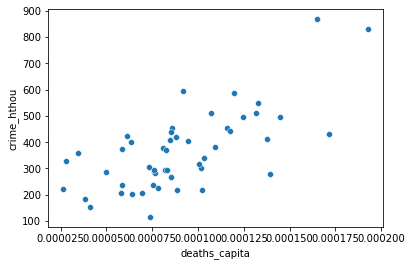

In [97]:
sns.scatterplot(data=spend_deaths_crime, x="deaths_capita", y="crime_hthou")

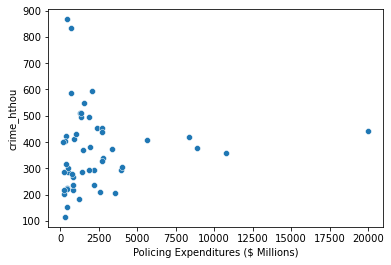

In [98]:
sns.scatterplot(data=spend_deaths_crime, x="Policing Expenditures ($ Millions)", y="crime_hthou")

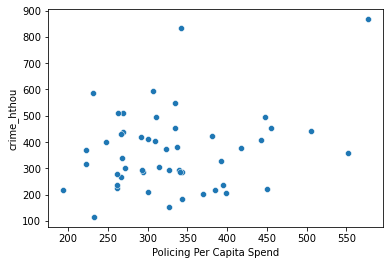

In [123]:
sns.scatterplot(data=spend_deaths_crime, x="Policing Per Capita Spend", y="crime_hthou")

### Clean data for line chart

In [216]:
import requests
import pandas as pd
from zipfile import ZipFile

#scrape police officers by city
# police_officers = pd.read_html('https://www.governing.com/gov-data/safety-justice/law-enforcement-police-department-employee-totals-for-cities.html')[0]
police_officers = pd.read_html('https://www.governing.com/gov-data/safety-justice/police-officers-per-capita-rates-employment-for-city-departments.html')
police_officers[2].to_csv(f'data/raw/police_officers_{data_cov}.csv')
police_officers = police_officers[2]

police_officers = pd.read_csv(f'data/raw/police_officers_{data_cov}.csv')

In [217]:
# population by race for US cities
# change race names to match fatal encounters
pop_race["Location of death (city)"] =  pop_race["City"] + ", " + pop_race["State Code"]
pop_race['Race'][pop_race['Race']=='Black or African-American'] = 'African-American/Black'
pop_race['Race'][pop_race['Race']=='White'] = 'European-American/White'
pop_race['Race'][pop_race['Race']=='Hispanic or Latino'] = 'Hispanic/Latino'

# subset race data for black white hispanic only and population only
pop_race = pop_race[pop_race['Race'].isin(['African-American/Black', 'European-American/White', 'Hispanic/Latino'])]
pop_race = pop_race[['Location of death (city)', 'Count', 'Total Population', "Race"]]

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [218]:
df = pd.read_csv(f'data/processed/fatal_encounters_cl_{data_cov}.csv')

In [13]:
# spending on police by state
spending = spending.replace({"DC":"District Of Columbia"})[~spending.State.str.contains("Data may be unavailable for some years")]
spending = pd.merge(state_abr.append({'name': 'United States', 'abbreviation': 'United States'}, ignore_index=True), spending, 
                    left_on='name', right_on='State', how='right')

spending['police_exp'] = pd.to_numeric(spending['(E019) Police & Fire Protection-Dir Exp'].str[1:]) + pd.to_numeric(spending['(E087) Police Prot-Direct Exp'].str[1:]) + pd.to_numeric(spending['(E088) Police Prot-Cur Oper (E62)'].str[1:]) + pd.to_numeric(spending['(E089) Police Prot-Cap Outlay'].str[1:])
spending = spending[['abbreviation', 'Year', 'police_exp']]
# spending = spending.drop(columns=["name", "State"])
# spending['State'][spending['State']!= 'United States'] = spending['State'] + ", " + spending['abbreviation']

In [219]:
# compute majority party by city
votes = votes[votes['year'] == 2016]
votes['county'] = votes['county'] + ", " + votes['state_po']
votes = votes[['county', 'party', 'candidatevotes']].dropna()

votes = votes.pivot_table(index = 'county', columns='party', values='candidatevotes').reset_index()
votes['party'] = "r"
votes['party'][votes['democrat']>votes['republican']] = 'blue'
votes['party'][votes['democrat']<votes['republican']] = 'red'
votes = votes[['county', 'party']].dropna()

city_key = pop[['city', 'county_name', 'state_id']]
city_key['city'], city_key['county_name'] = city_key["city"] + ", " + city_key["state_id"], city_key["county_name"] + ", " + city_key["state_id"]
votes = pd.merge(votes, city_key, left_on='county', right_on='county_name', how='left')
votes = votes[['city', 'party']].dropna()

# police officers by city
police_officers['State'] = police_officers['Police Department'].str.split(', ').str[1]
police_officers['City'] = police_officers['Police Department'].str.split(', ').str[0]
police_officers = pd.merge(police_officers, state_abr, left_on='State', right_on='name')
police_officers['city'] = police_officers['City'] + ", " + police_officers['abbreviation']
police_officers = police_officers[['city', 'Total Employees']]

df['Date (Year)'] = pd.to_datetime(df['Date of injury resulting in death (month/day/year)']).dt.year
df = df[df['Date (Year)']<=2020]

df = df[["Name", "Age", "Race", "Gender", 
         "Date of injury resulting in death (month/day/year)", 
         "Latitude", "Longitude", "Date (Year)", "Location of death (city)", "State"]]

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de

In [66]:
# # group by everything, month
# df['death_count'] = 1 

# df['month'] = df['Date of injury resulting in death (month/day/year)'].str[:2]

# df['month_year'] = df['month'].astype('str') + "/" + df['Date (Year)'].astype('str')

# df = df.groupby("month_year").agg(
#     { "Latitude": "mean", "Longitude": "mean", "death_count": "sum", "Date (Year)": "mean"}).reset_index()

In [21]:
# # group by race, month
# df['death_count'] = 1 

# df['month'] = df['Date of injury resulting in death (month/day/year)'].str[:2]

# df['month_year'] = df['month'].astype('str') + "/" + df['Date (Year)'].astype('str')

# df['Location of death (city)'] = df['Location of death (city)'].astype('str') + " city"

# df_month = df.groupby(["month_year", "Subject's race"]).agg(
#     { "Latitude": "mean", "Longitude": "mean", "death_count": "sum", "Date (Year)": "mean"}).reset_index()

# df = df.groupby(["Date (Year)", "Subject's race"]).agg(
#     { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()

In [220]:
# group by race, month, county

pop['city'] = pop['city'] + ", " + pop['state_id']
pop = pop[['city', 'population']]

# pop_race['City'] = pop_race['City'] + ", " + pop_race['State Code']
# pop = pop_race[['City', 'Total Population']]
# pop.columns = ['city', 'population']
# pop = pop.groupby('city').mean().reset_index()

df["Location of death (city)"] = df["Location of death (city)"] + ", " + df["State"]

df = pd.merge(df, pop, left_on='Location of death (city)', right_on='city')

police_officers = pd.merge(police_officers, pop, left_on='city', right_on='city')

# df = df[df['population']!=0][df['population']>100000]

df['death_count'] = 1 

df['month'] = df['Date of injury resulting in death (month/day/year)'].str[:2]

df['month_year'] = df['month'].astype('str') + "/" + df['Date (Year)'].astype('str')

# to numeric
df['Latitude'] = pd.to_numeric(df['Latitude'])
df['Longitude'] = pd.to_numeric(df['Longitude'])
df['death_count'] = pd.to_numeric(df['death_count'])
df['Date (Year)'] = pd.to_numeric(df['Date (Year)'])

df_month = df.groupby(["month_year", "Race", "Location of death (city)"]).agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum", "Date (Year)": "mean"}).reset_index()

# Aggregated Line chart by race
df_race = df.groupby(["Date (Year)", "Race", "Location of death (city)"]).agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum", "population": "mean"}).reset_index()

df_race = df_race[df_race["Race"].isin(['African-American/Black', 'Hispanic/Latino', 'European-American/White'])]

df_race = pd.merge(df_race, pop_race,  how='inner', left_on=["Race",'Location of death (city)'], right_on = ['Race','Location of death (city)'])

df_race = df_race.drop("population", axis = 1)
# test[test['Location of death (city)']=="Atlanta, GA"]
df_race_usa = df_race.groupby(["Date (Year)", "Race"]).agg(
        {"Latitude": "mean", "Longitude": "mean", "death_count": "sum", "Total Population": "mean", "Count": "sum"}).reset_index()

df_race_usa['Location of death (city)'] = "National Total"
df_race = df_race.append(df_race_usa)

df_race['death_hthou'] = df_race['death_count']/df_race['Count']*100000

# city year only
df = df.groupby(["Date (Year)", "Location of death (city)"]).agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum", "population": "mean"}).reset_index()

# compute total for United States
us_tot = df.groupby("Date (Year)").agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()
us_pop = us_pop.append(pd.DataFrame([['2020-01-01',331002651]], columns=['DATE', 'POPTOTUSA647NWDB']), ignore_index=True)
us_tot['population'] = np.array(us_pop[us_pop['DATE']>'1999-01-01']['POPTOTUSA647NWDB'])
us_tot['Location of death (city)'] = 'United States'

# # compute total for United States by race
# us_tot_race = df_race.groupby(["Date (Year)", "Race"]).agg(
#     { "Latitude": "mean", "Longitude": "mean", "death_count": "sum"}).reset_index()
# us_tot_race['population'] = np.append(np.array(us_pop[us_pop['DATE']>'1999-01-01']['POPTOTUSA647NWDB']), 0)
# us_tot_race['Location of death (city)'] = 'United States'

# police officers
# df = pd.merge(df, police_officers, left_on='Location of death (city)', right_on='city')
# df['population'] = df['population_x']
# df = df.drop(columns=['population_x', 'population_y', 'city'])

df = df.append(us_tot)
# df_race = df_race.append(us_tot_race)

df['death_hthou'] = df['death_count']/df['population']*100000
# df_race['death_hthou'] = df_race['death_count']/df_race['population']*1000000
police_officers['police_hthou'] = police_officers['Total Employees']/police_officers['population']*100000

### City Spending vs Police deaths

In [139]:
city_spending = pd.read_csv("data/raw/spending_city.csv")

In [140]:
city_spending['CITY $ PER RESIDENT FOR POLICE'] = pd.to_numeric(city_spending['CITY $ PER RESIDENT FOR POLICE'].str.strip("$"))
city_spending['PERCENT OF CITY FUNDS SPENT ON POLICING'] = pd.to_numeric(city_spending['PERCENT OF CITY FUNDS SPENT ON POLICING'].str.strip("%"))/100
city_spending['OVERALL POLICING BUDGET'] = city_spending['OVERALL POLICING BUDGET'].str.strip("$").str.replace(",", "")

In [147]:
city_spend_deaths = pd.merge(df, city_spending, left_on="Location of death (city)", right_on="CITY").drop("CITY", axis=1)

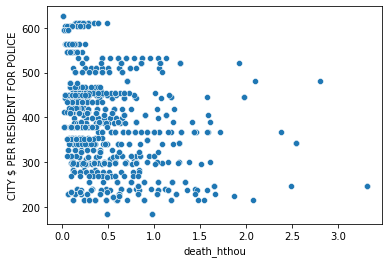

In [122]:
sns.scatterplot(data=city_spend_deaths[(city_spend_deaths['death_hthou']<4)&(city_spend_deaths['CITY $ PER RESIDENT FOR POLICE']<700)], x="death_hthou", y="CITY $ PER RESIDENT FOR POLICE")

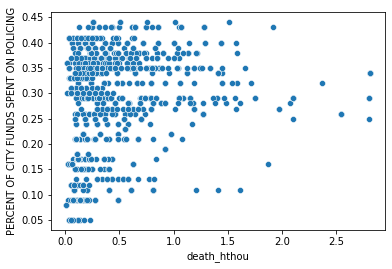

In [120]:
sns.scatterplot(data=city_spend_deaths[(city_spend_deaths['death_hthou']<4)&(city_spend_deaths['PERCENT OF CITY FUNDS SPENT ON POLICING']<0.5)], x="death_hthou", y="PERCENT OF CITY FUNDS SPENT ON POLICING")

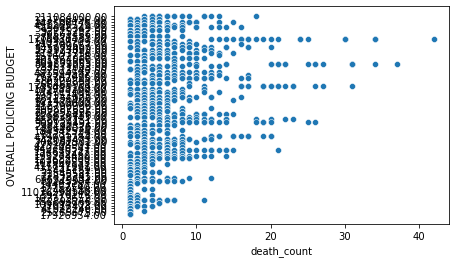

In [146]:
sns.scatterplot(data=city_spend_deaths, x="death_count", y="OVERALL POLICING BUDGET")

### Prepare data for deaths by race by city

In [92]:
df_race

,Date (Year),Race,Location of death (city),Latitude,Longitude,death_count,Count,Total Population,death_hthou
0,2000,African-American/Black,"Atlanta, GA",33.758454,-84.389228,2,245367,463875.000000,0.815106
1,2001,African-American/Black,"Atlanta, GA",33.760775,-84.382842,2,245367,463875.000000,0.815106
2,2002,African-American/Black,"Atlanta, GA",33.715428,-84.419019,2,245367,463875.000000,0.815106
3,2003,African-American/Black,"Atlanta, GA",33.946915,-84.539537,1,245367,463875.000000,0.407553
4,2006,African-American/Black,"Atlanta, GA",33.753291,-84.382133,2,245367,463875.000000,0.815106
...,...,...,...,...,...,...,...,...,...
58,2019,European-American/White,National Total,37.497761,-100.142884,222,31202172,336664.942857,0.711489
59,2019,Hispanic/Latino,National Total,35.362824,-104.216124,142,12588267,365928.348837,1.128035
60,2020,African-American/Black,National Total,36.585144,-93.114932,210,11040538,385608.518519,1.902081
61,2020,European-American/White,National Total,37.523533,-99.142116,169,24311059,282917.744000,0.695157


In [203]:
df_race = df_race.drop(['Latitude', 'Longitude', "Count"], axis=1)
df_race.columns = ['date', 'race', 'city', 'death_count', 'race_pop', 'death_hthou']

In [204]:
df_race

,date,race,city,death_count,race_pop,death_hthou
0,2000,African-American/Black,"Atlanta, GA",2,463875.000000,0.815106
1,2001,African-American/Black,"Atlanta, GA",2,463875.000000,0.815106
2,2002,African-American/Black,"Atlanta, GA",2,463875.000000,0.815106
3,2003,African-American/Black,"Atlanta, GA",1,463875.000000,0.407553
4,2006,African-American/Black,"Atlanta, GA",2,463875.000000,0.815106
...,...,...,...,...,...,...
58,2019,European-American/White,National Total,222,336664.942857,0.711489
59,2019,Hispanic/Latino,National Total,142,365928.348837,1.128035
60,2020,African-American/Black,National Total,210,385608.518519,1.902081
61,2020,European-American/White,National Total,169,282917.744000,0.695157


In [157]:
test = df_race.pivot_table(index=['date', 'city'], columns='race',
                           values='death_hthou').reset_index().rename(columns = {'African-American/Black': 'black', 
                                                                    'European-American/White': 'white', 
                                                                    'Hispanic/Latino': 'latino'}).sort_values(['city', 'date'])

test['black'] = test['black'].interpolate()
test['white'] = test['white'].interpolate()
test['latino'] = test['latino'].interpolate()
test.to_csv(f"data/processed/deaths_by_race_city_year_{data_cov}.csv")

In [373]:
# df_race = df_race.pivot_table(index=['date', 'city'], columns='race',
#                            values='death_hthou').reset_index().rename(columns = {'African-American/Black': 'black', 
#                                                                     'European-American/White': 'white', 
#                                                                     'Hispanic/Latino': 'latino'})

# df_race.to_csv("data/deaths_by_race_city_year.csv")

### normalized map


In [205]:
# add party
df = pd.merge(df, votes, left_on='Location of death (city)', right_on='city', how='inner')#.drop('county', axis=1)

In [206]:
# by year
df[["Latitude", "Longitude","death_count", "death_hthou"]] = df[["Latitude", "Longitude","death_count", "death_hthou"]].apply(pd.to_numeric)


df = df.groupby(["Location of death (city)", "Date (Year)", "party"]).agg(
    { "Latitude": "mean", "Longitude": "mean", "death_count": "sum", "death_hthou": "mean", "population":"mean"}).reset_index()

df.columns = ["county", "date", "party", "Latitude", "Longitude","death_count", "death_hthou", "population"]

In [208]:
df[df['county']!="United States"].to_csv(f"data/processed/citiesYearDeathsHT_party_n_{data_cov}.csv")

### Small Multiples

In [434]:
# # for small multiples
# df = df[df['Date (Year)'].isin([2000, 2010, 2019])].drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
#          values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
#                                                                     'Location of death (city)': 'county'}).dropna(subset=[2000, 2019])

# # df = df.drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
# #          values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
# #                                                                     'Location of death (city)': 'county'}).dropna(subset=[2000, 2019])

# df['change'] = df[2019] - df[2000]
# df['%_change'] = ((df[2019] - df[2000])/df[2000])*100


# ## Sort by % change
# df_most = df.sort_values('%_change', ascending=False).head(20).append(df[df['county']=='United States'])
# df_least = df.sort_values('%_change', ascending=True).head(20).append(df[df['county']=='United States'])

# # Sort by number of Officers

# df_most = pd.melt(df_most, id_vars = ['county', '%_change'], value_vars=[2000, 2010, 2019]).rename(columns = {'county': 'city', 
#                                                                     'Date (Year)': 'year'})

# df_least = pd.melt(df_least, id_vars = ['county', '%_change'], value_vars=[2000, 2010, 2019]).rename(columns = {'county': 'city', 
#                                                                     'Date (Year)': 'year'})



# df_most.to_csv('deaths_by_city_sm_most.csv')
# df_least.to_csv('deaths_by_city_sm_least.csv')

### Pick Up Here!

### Police officers by City

In [221]:
# years = [2000, 2010, 2020] #[2000, 2010, 2019] #np.arange(2000, 2020)
years = list(np.arange(2000, 2021, 1))
chart_wanted = "SM" # SM for small multiples and SC for scatter

# for scatter plot and small multiples by police officers
df = df[df['Date (Year)'].isin(years)].drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
         values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
                                                                    'Location of death (city)': 'county'}).dropna(subset=[2000])

# df = df.drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
#          values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
#                                                                     'Location of death (city)': 'county'}).dropna(subset=[2000, 2019])

df['change'] = df[years[-1]] - df[years[0]]
df['%_change'] = ((df[years[-1]] - df[years[0]])/df[years[0]])*100

if chart_wanted == "SC":
    df = pd.merge(df, police_officers, left_on='county', right_on='city').drop('city', axis=1).append(df[df['county']=='United States'])

    df = df[df['county']!='Newark, NJ']

## Sort by % change
    df_most = df.sort_values('police_hthou', ascending=False).head(20).append(df[df['county']=='United States'])
    df_least = df.sort_values('police_hthou', ascending=True).head(20).append(df[df['county']=='United States'])

    df_most = pd.melt(df_most, id_vars = ['county', '%_change'], value_vars=years).rename(columns = {'county': 'city', 
                                                                        'variable': 'year'})

    df_least = pd.melt(df_least, id_vars = ['county', '%_change'], value_vars=years).rename(columns = {'county': 'city', 
                                                                        'variable': 'year'})

# df.columns = df.columns.astype('str')

# party
df_votes = pd.merge(df, votes, left_on='county', right_on='city', how='inner')#.drop('county', axis=1)

if chart_wanted == "SM":
    df_party = pd.merge(df_votes, pop, on='city')
    df_red = df_party[df_party['party']=='red'].sort_values('population', ascending=False).dropna(subset=[2000,2020]).head(20)
    df_blue = df_party[df_party['party']=='blue'].sort_values('population', ascending=False).dropna(subset=[2000,2020]).head(20)
    df_party = df_red.append(df_blue).sort_values('population', ascending=False).drop('population', axis = 1)
    
    # sort by party
    df = df.rename(columns={"county": "city"})
    df_party = pd.melt(df_party.append(df[df['city']=='United States']), id_vars = ['city', '%_change', 'party'], 
                                       value_vars=years).rename(columns = {'city': 'city','variable': 'year'})


df_votes = df_votes.drop('county', axis=1)
# df_votes.columns = ['d_2000', 'd_2010', 'd_2020', 'change', '%_change', 'Total Employees', 'population', 'police_hthou', 'city', 'party']
df_votes.columns = ['d_2000', 'd_2001','d_2002','d_2003','d_2004','d_2005','d_2006','d_2007','d_2008', 'd_2009', 
                    'd_2010','d_2011','d_2012','d_2013','d_2014','d_2015','d_2016','d_2017','d_2018','d_2019', 
                    'd_2020', 'change', '%_change', 'Total Employees', 'population', 'police_hthou', 'city', 'party']

# df_votes.to_csv('deaths_vs_officers.csv')
# df_most.to_csv('deaths_by_city_sm_mostp_ty.csv')
# df_least.to_csv('deaths_by_city_sm_leastp_line_ty.csv')
# df_party.to_csv('death_by_city_party.csv')

In [130]:
df_votes.to_csv(f'data/processed/deaths_vs_officers_20years_{data_cov}.csv')

In [223]:
df_party.to_csv(f'data/processed/death_by_city_party_{data_cov}.csv')

In [9]:
# df_party = pd.merge(df_votes, pop, on='city')
# df_red = df_party[df_party['party']=='red'].sort_values('population', ascending=False).dropna().head(10)
# df_blue = df_party[df_party['party']=='blue'].sort_values('population', ascending=False).dropna().head(10)
# df_party = df_red.append(df_blue).sort_values('population', ascending=False).drop('population', axis = 1)


### Aggregated party over time

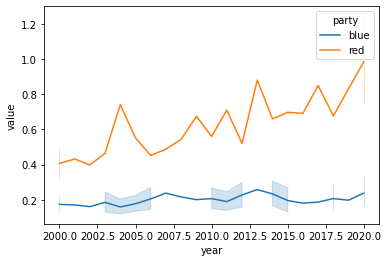

In [231]:
import seaborn as sns
df_party_agg = df_party.groupby(['year', 'party']).mean().reset_index()
sns.lineplot(data = df_party, x = 'year', y='value', hue='party')

In [232]:
df_party_agg = df_party_agg.pivot(index = 'year', columns='party', 
         values='value').reset_index()

df_party_agg.to_csv(f'data/processed/death_by_city_party_agg_{data_cov}.csv')

In [233]:
df_party_agg

party,year,blue,red
0,2000,0.173701,0.405434
1,2001,0.170424,0.431629
2,2002,0.160849,0.397974
3,2003,0.185224,0.463922
4,2004,0.159002,0.740310
5,2005,0.177213,0.550806
6,2006,0.204830,0.451683
7,2007,0.237609,0.487461
8,2008,0.215841,0.543656
9,2009,0.200450,0.674025


### Per Capita Police Spending by City

In [422]:
df['state'] = df['city'].str.split(', ').str[1]

df = pd.merge(df, spending[spending['Year']=='2017'], left_on='state', right_on='abbreviation').drop(['Year', 'abbreviation'], axis=1)

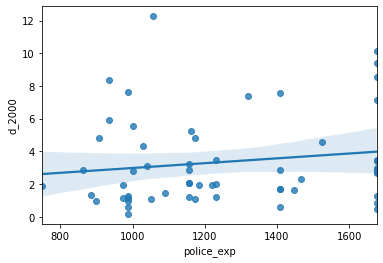

In [434]:
import seaborn as sns
sns.regplot(data = df, x='police_exp', y='d_2000')

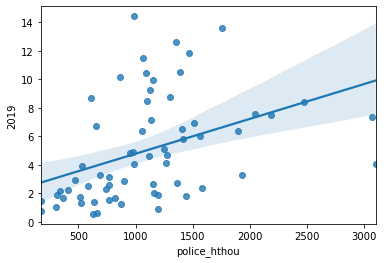

In [60]:
import seaborn as sns
sns.regplot(data = df[df['county']!='Newark, NJ'], x='police_hthou', y=df[2019])

In [315]:
# for small multiples all data points
# df = df[df['Date (Year)'].isin([2000, 2010, 2019])].drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
#          values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
#                                                                     'Location of death (city)': 'county'}).dropna()

df = df.drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
         values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
                                                                    'Location of death (city)': 'county'}).dropna(subset=[2000, 2019])

df['change'] = df[2019] - df[2000]
df['%_change'] = ((df[2019] - df[2000])/df[2000])*100

df_most = df.sort_values('%_change', ascending=False).head(20).append(df[df['county']=='United States'])
df_least = df.sort_values('%_change', ascending=True).head(20).append(df[df['county']=='United States'])

# df_most = pd.melt(df_most, id_vars = ['county', '%_change'], value_vars=list(np.arange(2000, 2020))).rename(columns = {'county': 'city', 
#                                                                     'Date (Year)': 'year'})

# df_least = pd.melt(df_least, id_vars = ['county', '%_change'], value_vars=list(np.arange(2000, 2020))).rename(columns = {'county': 'city', 
#                                                                     'Date (Year)': 'year'})

# df_most.to_csv('deaths_by_city_sm_most.csv')
# df_least.to_csv('deaths_by_city_sm_least.csv')

In [8]:
# for scatter plot and small multiples by police officers all data points
df = df.drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
         values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
                                                                    'Location of death (city)': 'county'}).dropna(subset=[2000, 2019])

# df = df.drop(['Latitude', 'Longitude'], axis=1).pivot(index = 'Location of death (city)', columns='Date (Year)', 
#          values='death_hthou').reset_index().rename(columns = {'Date (Year)': 'date', 
#                                                                     'Location of death (city)': 'county'}).dropna(subset=[2000, 2019])

df['change'] = df[2019] - df[2000]
df['%_change'] = ((df[2019] - df[2000])/df[2000])*100

df = pd.merge(df, police_officers, left_on='county', right_on='city').drop('city', axis=1).append(df[df['county']=='United States'])

df = df[df['county']!='Newark, NJ']
df = df[df['county']!='Bakersfield, CA']

## Sort by % change
df_most = df.sort_values('police_hthou', ascending=False).head(20).append(df[df['county']=='United States'])
df_least = df.sort_values('police_hthou', ascending=True).head(20).append(df[df['county']=='United States'])

# Sort by number of Officers

df_most = pd.melt(df_most, id_vars = ['county', '%_change'], value_vars=list(np.arange(2000, 2020))).rename(columns = {'county': 'city', 
                                                                    'variable': 'year'})

df_least = pd.melt(df_least, id_vars = ['county', '%_change'], value_vars=list(np.arange(2000, 2020))).rename(columns = {'county': 'city', 
                                                                    'variable': 'year'})

df.columns = ['']

df.to_csv('deaths_vs_officers.csv')
# df_most.to_csv('deaths_by_city_sm_mostp_all.csv')
# df_least.to_csv('deaths_by_city_sm_leastp_all.csv')

In [22]:
df["Race"].unique()
df = df[df["Race"].isin(['African-American/Black', 'Hispanic/Latino', 'European-American/White'])]

df_month["Race"].unique()
df_month = df_month[df_month["Race"].isin(['African-American/Black', 'Hispanic/Latino', 'European-American/White'])]

In [23]:
# df['race_pop'][df["Race"]=="African-American/Black"][df["Date (Year)"]==2000]
# df['race_pop'][df["Race"]=="African-American/Black"][df["Date (Year)"]==2000]
# df['race_pop'][df["Race"]=="African-American/Black"][df["Date (Year)"]==2000]

In [25]:
import seaborn as sns
# df['month_year'] = pd.to_datetime(df['month_year']) 
df['race_pop'] = 0

df['race_pop'][df["Race"]=="African-American/Black"] = 44080000
df['race_pop'][df["Race"]=='European-American/White'] = 250520000
df['race_pop'][df["Race"]=='Hispanic/Latino'] = 52000000

df_month['race_pop'] = 0

df_month['race_pop'][df_month["Race"]=="African-American/Black"] = 44080000
df_month['race_pop'][df_month["Race"]=='European-American/White'] = 250520000
df_month['race_pop'][df_month["Race"]=='Hispanic/Latino'] = 52000000

In [30]:
df['deaths_hThousands'] = df['death_count']/df['race_pop']*1000000
df = df[df["Date (Year)"]<2020]
df['pop_prop'] = df['race_pop']/328200000
df.columns = ["date", "race", 'Latitude', 'Longitude', 'death_count', 'race_pop', 'deaths_thousands', 'pop_prop']
df = df[["date", "race", 'death_count', 'race_pop', 'deaths_thousands', 'pop_prop']]

df_month['deaths_hThousands'] = df_month['death_count']/df_month['race_pop']*1000000
df_month = df_month[df_month["Date (Year)"]<2020]
df_month['pop_prop'] = df_month['race_pop']/328200000
df_month = df_month.drop('Date (Year)', axis=1)
df_month.columns = ["date", "race", 'Latitude', 'Longitude', 'death_count', 'race_pop', 'deaths_thousands', 'pop_prop']
df_month = df_month[["date", "race", 'death_count', 'race_pop', 'deaths_thousands', 'pop_prop']]

In [31]:
df_month

,date,race,death_count,race_pop,deaths_thousands,pop_prop
0,01/2000,African-American/Black,13,44080000,0.294918,0.134308
2,01/2000,European-American/White,16,250520000,0.063867,0.763315
3,01/2000,Hispanic/Latino,5,52000000,0.096154,0.158440
6,01/2001,African-American/Black,8,44080000,0.181488,0.134308
8,01/2001,European-American/White,6,250520000,0.023950,0.763315
...,...,...,...,...,...,...
1364,12/2018,European-American/White,51,250520000,0.203577,0.763315
1365,12/2018,Hispanic/Latino,24,52000000,0.461538,0.158440
1368,12/2019,African-American/Black,42,44080000,0.952813,0.134308
1370,12/2019,European-American/White,67,250520000,0.267444,0.763315


In [165]:
test

,Date (Year),Subject's race,Latitude,Longitude,death_count,Total Population,Count,death_hthou
0,2000,African-American/Black,36.089207,-95.725438,75,556874.500000,7274893,10.309430
1,2000,European-American/White,36.842549,-102.338321,48,567799.897436,13908545,3.451116
2,2000,Hispanic/Latino,35.725296,-108.772303,35,731542.826087,6406818,5.462930
3,2001,African-American/Black,36.632090,-98.076589,59,552944.702703,4596612,12.835541
4,2001,European-American/White,38.801837,-105.049861,55,489274.761905,12723955,4.322555
...,...,...,...,...,...,...,...,...
58,2019,European-American/White,37.497761,-100.142884,222,336664.942857,31202172,7.114889
59,2019,Hispanic/Latino,35.362824,-104.216124,142,365928.348837,12588267,11.280345
60,2020,African-American/Black,36.255124,-92.519017,152,377526.112360,9759989,15.573788
61,2020,European-American/White,37.277020,-99.184543,132,289796.466019,20558108,6.420824


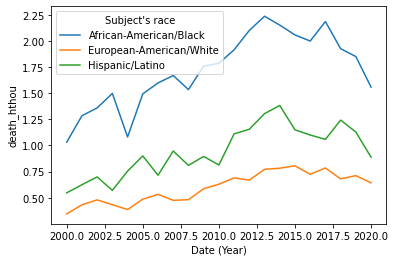

In [168]:
import seaborn as sns
sns.lineplot(data = test, x = "Date (Year)", y = 'death_hthou', hue="Race")

In [18]:
df.head(5)

,date,race,death_count,race_pop,deaths_thousands,pop_prop
0,2000,African-American/Black,122,44080000,2.767695,0.134308
2,2000,European-American/White,120,250520000,0.479004,0.763315
3,2000,Hispanic/Latino,54,52000000,1.038462,0.158440
6,2001,African-American/Black,92,44080000,2.087114,0.134308
8,2001,European-American/White,118,250520000,0.471020,0.763315


In [39]:
df_month['date'] = pd.to_datetime(df_month['date']) 

,date,race,death_count,race_pop,deaths_thousands,pop_prop
0,2000-01-01,African-American/Black,13,44080000,0.294918,0.134308
2,2000-01-01,European-American/White,16,250520000,0.063867,0.763315
3,2000-01-01,Hispanic/Latino,5,52000000,0.096154,0.158440
6,2001-01-01,African-American/Black,8,44080000,0.181488,0.134308
8,2001-01-01,European-American/White,6,250520000,0.023950,0.763315
...,...,...,...,...,...,...
1364,2018-12-01,European-American/White,51,250520000,0.203577,0.763315
1365,2018-12-01,Hispanic/Latino,24,52000000,0.461538,0.158440
1368,2019-12-01,African-American/Black,42,44080000,0.952813,0.134308
1370,2019-12-01,European-American/White,67,250520000,0.267444,0.763315


In [41]:
# df_month.pivot(index='date', columns='race', 
#          values='deaths_thousands').reset_index().rename(columns = {'African-American/Black': 'black', 
#                                                                     'European-American/White': 'white', 
#                                                                     'Hispanic/Latino': 'latino'})

In [42]:
# df.pivot(index='date', columns='race', 
#          values='deaths_thousands').reset_index().rename(columns = {'African-American/Black': 'black', 
#                                                                     'European-American/White': 'white', 
#                                                                     'Hispanic/Latino': 'latino'}).to_csv("deaths_by_race.csv")
df_month.pivot(index='date', columns='race', 
         values='deaths_thousands').reset_index().rename(columns = {'African-American/Black': 'black', 
                                                                    'European-American/White': 'white', 
                                                                    'Hispanic/Latino': 'latino'}).to_csv("deaths_by_race_month.csv")

# df.groupby('date').mean().reset_index().to_csv('deaths_time.csv')

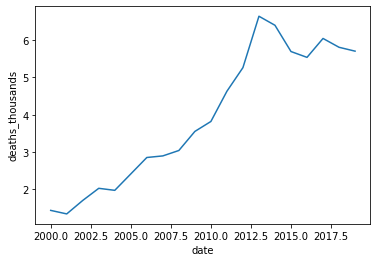

In [38]:
sns.lineplot(data = df.groupby('date').mean().reset_index(), x = "date", y = 'deaths_thousands')

In [223]:
counties_deaths = pd.merge(counties, df, left_on="NAME", 
                           right_on = "Location of death (county)", 
                           how = "left")

counties_deaths = counties_deaths[['NAME','geometry', 'death_count']]

In [225]:
counties_deaths['death_count'] = counties_deaths['death_count'].fillna(0)

In [111]:
# counties_deaths.geometry = counties_deaths.centroid

In [226]:
counties_deaths['Longitude'] = counties_deaths.geometry.centroid.x
counties_deaths['Latitude'] = counties_deaths.geometry.centroid.y

In [227]:
counties_deaths

,NAME,geometry,death_count,Longitude,Latitude
0,Cuming,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",0.0,-96.787400,41.916403
1,Wahkiakum,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",0.0,-123.433470,46.291134
2,De Baca,"POLYGON ((-104.56739 33.99757, -104.56772 33.9...",1.0,-104.411958,34.342414
3,Lancaster,"POLYGON ((-96.91060 40.95841, -96.91060 40.958...",48.0,-96.687756,40.784174
4,Nuckolls,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",0.0,-98.047185,40.176380
...,...,...,...,...,...
3228,Gilmer,"POLYGON ((-84.65478 34.66559, -84.65488 34.669...",0.0,-84.455627,34.691178
3229,Roseau,"POLYGON ((-96.40466 48.80528, -96.40467 48.813...",0.0,-95.810817,48.775139
3230,Madison,"POLYGON ((-90.09363 32.70763, -90.09360 32.707...",142.0,-90.033714,32.634710
3231,Howard,"POLYGON ((-101.69227 32.27106, -101.69221 32.2...",26.0,-101.435505,32.306169


In [156]:
counties_deaths = counties_deaths.dropna()
counties_deaths = counties_deaths[['NAME','death_count', 'Longitude', 'Latitude']]
counties_deaths.shape

(2728, 4)

In [234]:
counties_deaths.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3233 entries, 0 to 3232
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   NAME         3233 non-null   object  
 1   geometry     3233 non-null   geometry
 2   death_count  3233 non-null   float64 
 3   Longitude    3233 non-null   float64 
 4   Latitude     3233 non-null   float64 
dtypes: float64(3), geometry(1), object(1)
memory usage: 151.5+ KB


In [236]:
counties_deaths.dropna().to_file('counties_deaths_cl.geojson', driver="GeoJSON")

In [233]:
counties_deaths

,NAME,geometry,death_count,Longitude,Latitude
0,Cuming,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",0.0,-96.787400,41.916403
1,Wahkiakum,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",0.0,-123.433470,46.291134
2,De Baca,"POLYGON ((-104.56739 33.99757, -104.56772 33.9...",1.0,-104.411958,34.342414
3,Lancaster,"POLYGON ((-96.91060 40.95841, -96.91060 40.958...",48.0,-96.687756,40.784174
4,Nuckolls,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",0.0,-98.047185,40.176380
...,...,...,...,...,...
3228,Gilmer,"POLYGON ((-84.65478 34.66559, -84.65488 34.669...",0.0,-84.455627,34.691178
3229,Roseau,"POLYGON ((-96.40466 48.80528, -96.40467 48.813...",0.0,-95.810817,48.775139
3230,Madison,"POLYGON ((-90.09363 32.70763, -90.09360 32.707...",142.0,-90.033714,32.634710
3231,Howard,"POLYGON ((-101.69227 32.27106, -101.69221 32.2...",26.0,-101.435505,32.306169
